# Question 1 - Noise Reduction with Moving Average Filters



## (a) Implement and compare logarithmic and power-law (gamma correction) transformations for enhancing an image.

In [99]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.util import random_noise
import matplotlib.pyplot as plt
import pandas as pd

img = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

### Load a grayscale or color image and add Gaussian noise / salt-and-pepper noise.


In [100]:
noisy_img_gaussian = random_noise(img, mode='gaussian', var=0.005)
noisy_img_gaussian = np.array(255 * noisy_img_gaussian, dtype='uint8')

In [101]:
noisy_img_sp = random_noise(img, mode='s&p', amount=0.01)
noisy_img_sp = np.array(255 * noisy_img_sp, dtype='uint8')

### Moving average filters with different kernel sizes

In [102]:
kernel_sizes = [(3, 3), (5, 5), (7, 7), (3, 5)]
filtered_images = []

In [103]:
for kernel_size in kernel_sizes:
    filtered_img = cv2.blur(noisy_img_gaussian, kernel_size)
    filtered_images.append(filtered_img)
    filtered_img = cv2.blur(noisy_img_sp, kernel_size)
    filtered_images.append(filtered_img)

### Compare the filtered images to observe the trade-offs between noise reduction and blurring of edges.

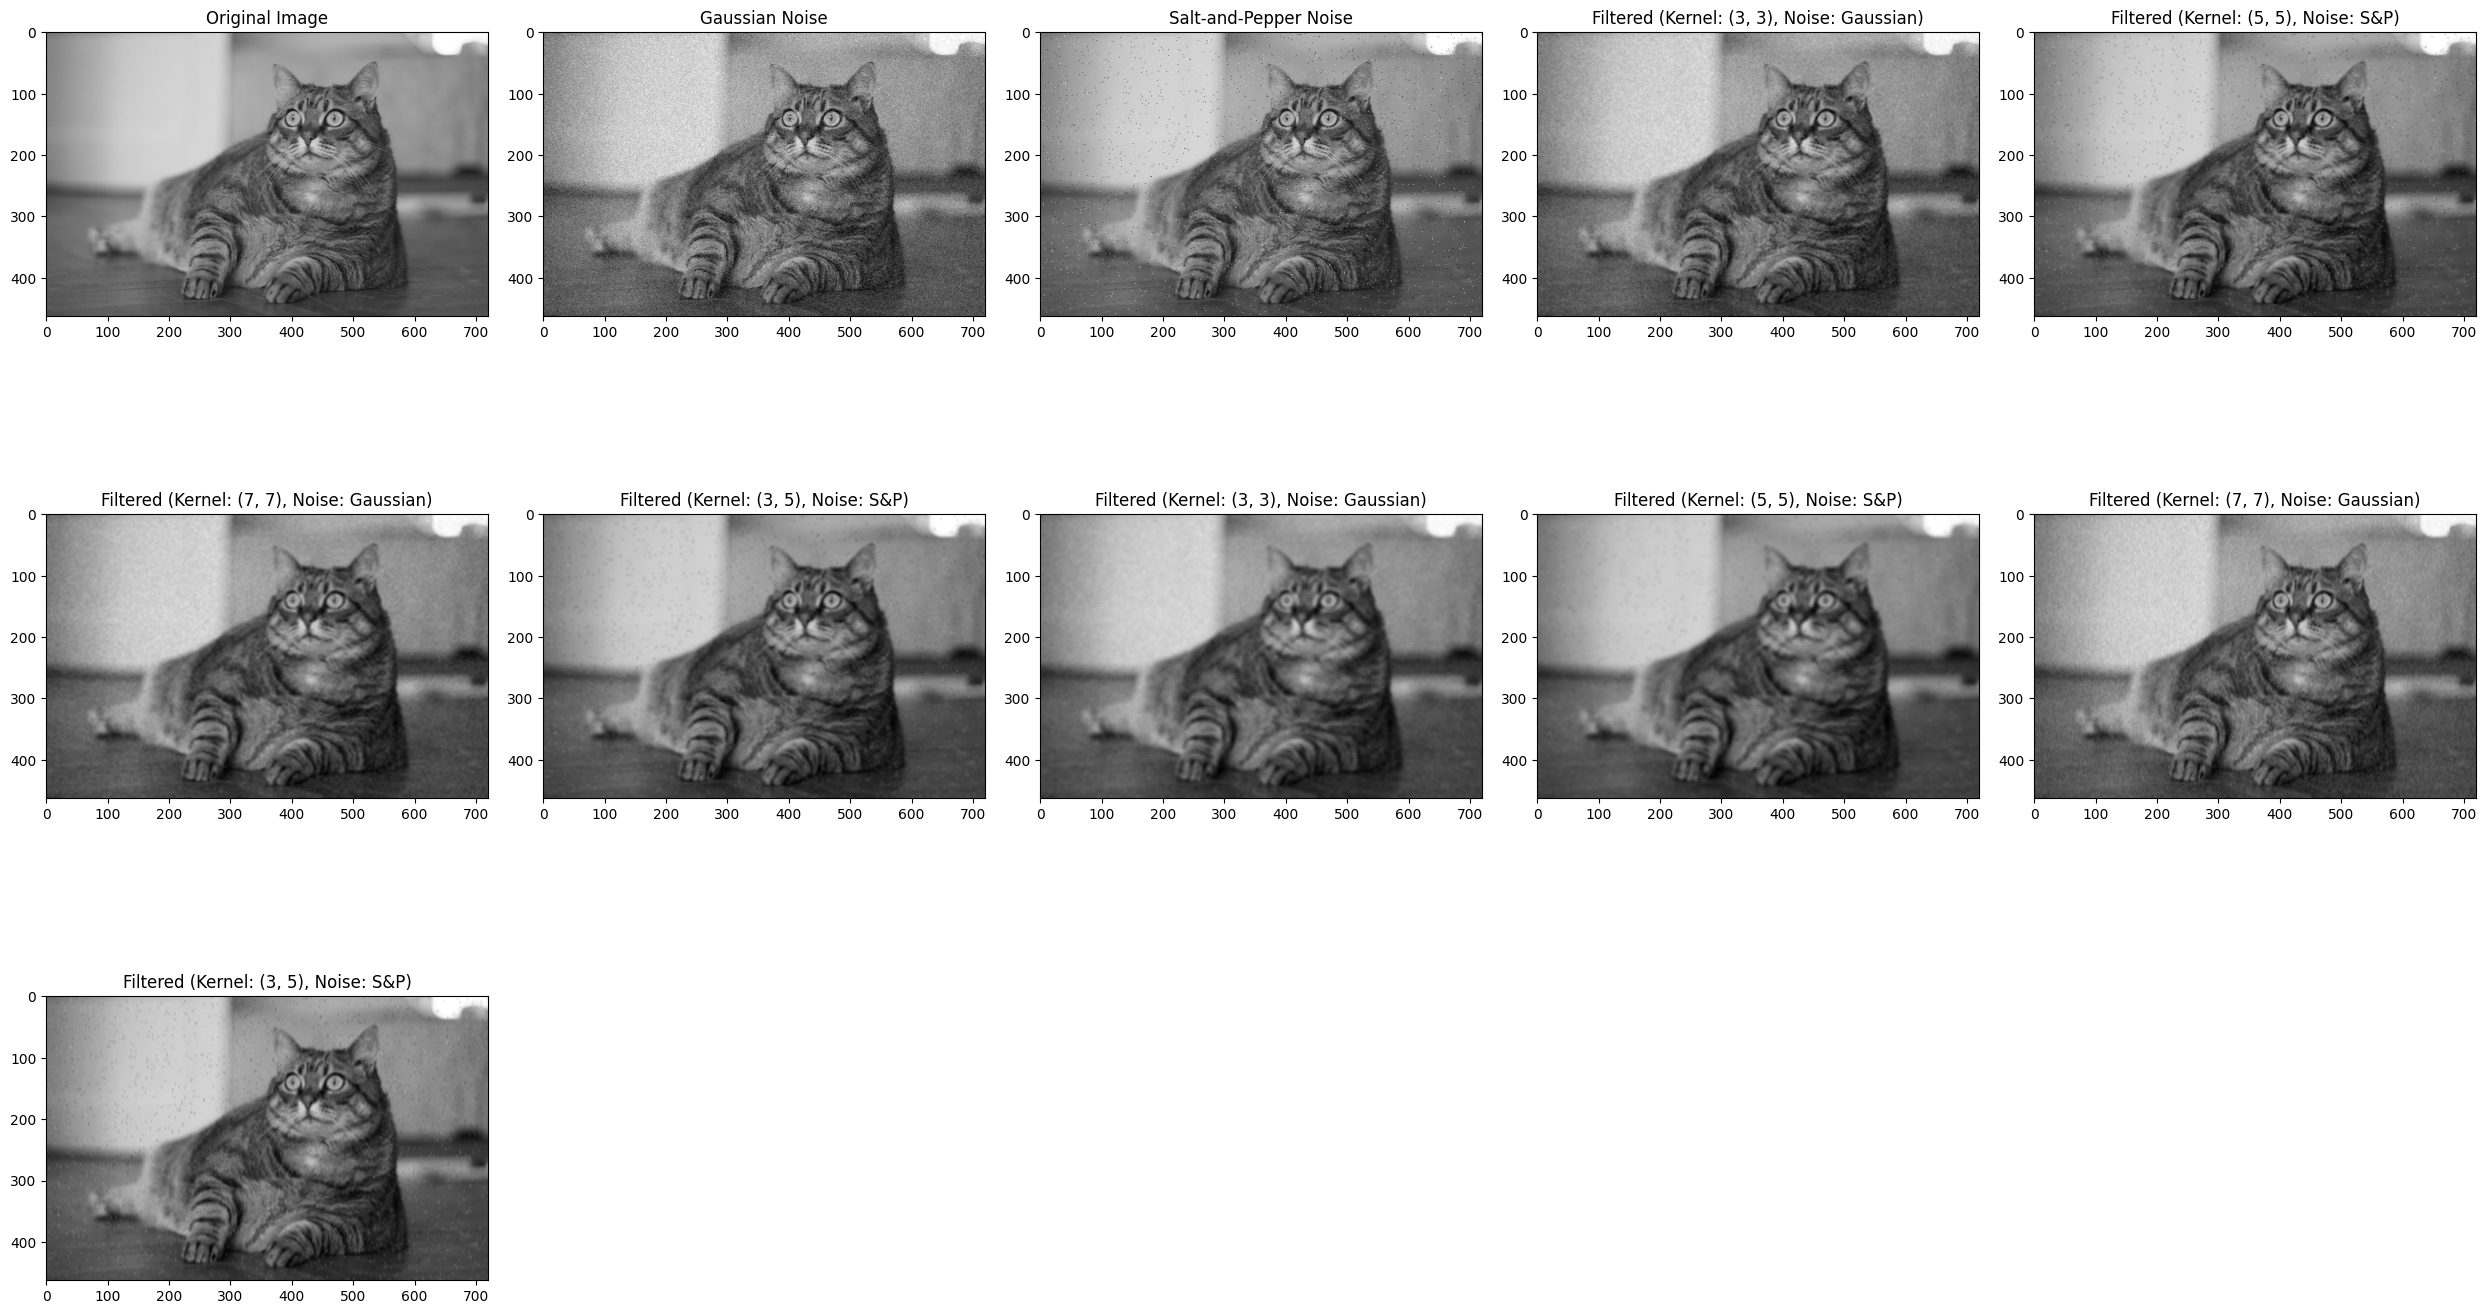

In [104]:
plt.figure(figsize=(25, 15))

plt.subplot(3, 5, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(3, 5, 2)
plt.imshow(noisy_img_gaussian, cmap='gray')
plt.title('Gaussian Noise')

plt.subplot(3, 5, 3)
plt.imshow(noisy_img_sp, cmap='gray')
plt.title('Salt-and-Pepper Noise')


for i, filtered_img in enumerate(filtered_images):
    plt.subplot(3, 5, i + 4)
    plt.imshow(filtered_img, cmap='gray')

    kernel_size = kernel_sizes[i % len(kernel_sizes)]

    noise_type = "Gaussian" if i % 2 == 0 else "S&P"
    plt.title(f'Filtered (Kernel: {kernel_size}, Noise: {noise_type})')

plt.tight_layout()
plt.show()

### Compute PSNR(Peak Signal-to-Noise Ratio ) and SSIM (Structural Similarity Index) to quantitatively evaluate the filtering performance.

In [105]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr


psnr_values = []
ssim_values = []

for filtered_img in filtered_images:
    psnr = calculate_psnr(img, filtered_img)
    psnr_values.append(psnr)
    ssim_val = ssim(img, filtered_img, data_range=filtered_img.max() - filtered_img.min())
    ssim_values.append(ssim_val)

In [106]:
data = []
for i, kernel_size in enumerate(kernel_sizes):
    data.append({
        "Kernel Size": kernel_size,
        "Noise Type": "Gaussian",
        "PSNR": psnr_values[2 * i],
        "SSIM": ssim_values[2 * i]
    })
    data.append({
        "Kernel Size": kernel_size,
        "Noise Type": "S&P",
        "PSNR": psnr_values[2 * i + 1],
        "SSIM": ssim_values[2 * i + 1]
    })

metrics_table = pd.DataFrame(data)
display(metrics_table)

,Kernel Size,Noise Type,PSNR,SSIM
0,"(3, 3)",Gaussian,32.113990,0.721342
1,"(3, 3)",S&P,35.560150,0.831884
2,"(5, 5)",Gaussian,33.584723,0.806734
3,"(5, 5)",S&P,34.404688,0.845044
4,"(7, 7)",Gaussian,33.803126,0.814845
5,"(7, 7)",S&P,34.195161,0.830677
6,"(3, 5)",Gaussian,32.919675,0.769975
7,"(3, 5)",S&P,34.239960,0.833834


## (b) Design an adaptive moving average filter where the kernel size adjusts based on local variance in the image.

In [107]:
def adaptive_moving_average_filter(image, window_size=5, var_threshold=100):

    filtered_image = np.zeros_like(image, dtype=np.float64)
    height, width = image.shape

    for i in range(height):
        for j in range(width):
            window = image[max(0, i - window_size // 2):min(height, i + window_size // 2 + 1),
                          max(0, j - window_size // 2):min(width, j + window_size // 2 + 1)]
            local_variance = np.var(window)

            kernel_size = 3 if local_variance > var_threshold else 7

            kernel = np.ones((kernel_size, kernel_size), dtype=np.float64) / (kernel_size ** 2)

            region = image[max(0, i - kernel_size // 2):min(height, i + kernel_size // 2 + 1),
                           max(0, j - kernel_size // 2):min(width, j + kernel_size // 2 + 1)]

            if region.shape == kernel.shape:
                filtered_image[i, j] = np.sum(region * kernel)

    return filtered_image.astype(np.uint8)

In [108]:
filtered_img_gaussian_adaptive = adaptive_moving_average_filter(noisy_img_gaussian)
filtered_img_sp_adaptive = adaptive_moving_average_filter(noisy_img_sp)

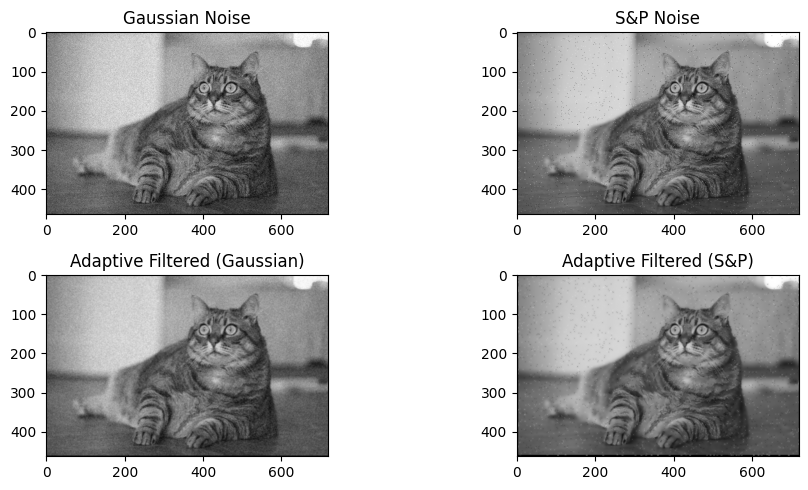

In [109]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(noisy_img_gaussian, cmap='gray')
plt.title('Gaussian Noise')

plt.subplot(2, 2, 2)
plt.imshow(noisy_img_sp, cmap='gray')
plt.title('S&P Noise')

plt.subplot(2, 2, 3)
plt.imshow(filtered_img_gaussian_adaptive, cmap='gray')
plt.title('Adaptive Filtered (Gaussian)')

plt.subplot(2, 2, 4)
plt.imshow(filtered_img_sp_adaptive, cmap='gray')
plt.title('Adaptive Filtered (S&P)')

plt.tight_layout()
plt.show()

# Question 2 - Convolution-Based Feature Extraction for Pattern Detection
Use convolution with custom filters to detect patterns in an image (e.g., lines, corners, or specific shapes).

In [110]:
image = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

## Design custom convolution kernels for detecting horizontal, vertical, and diagonal lines,anti diagonal, corner .

In [111]:
horizontal_kernel = np.array([[-1, -1, -1],
                              [2, 2, 2],
                              [-1, -1, -1]])

vertical_kernel = np.array([[-1, 2, -1],
                            [-1, 2, -1],
                            [-1, 2, -1]])

diagonal_kernel = np.array([[-1, -1, 2],
                             [-1, 2, -1],
                             [2, -1, -1]])

anti_diagonal_kernel = np.array([[2, -1, -1],
                                 [-1, 2, -1],
                                 [-1, -1, 2]])

corner_kernel_1 = np.array([[-1, -1, 2],
                            [-1, 2, -1],
                            [-1, -1, -1]])

corner_kernel_2 = np.array([[2, -1, -1],
                            [-1, 2, -1],
                            [-1, -1, -1]])

## Convolve the kernels with an image to highlight specific patterns.

In [112]:
horizontal_lines = cv2.filter2D(image, -1, horizontal_kernel)
vertical_lines = cv2.filter2D(image, -1, vertical_kernel)
diagonal_lines = cv2.filter2D(image, -1, diagonal_kernel)
anti_diagonal_lines = cv2.filter2D(image, -1, anti_diagonal_kernel)

## Experiment with detecting corners using a combination of line-detection filters.

In [113]:
corner1 = cv2.filter2D(image, -1, corner_kernel_1)
corner2 = cv2.filter2D(image, -1, corner_kernel_2)

## Visualize the outputs and analyze how convolution kernels enhance specific features.

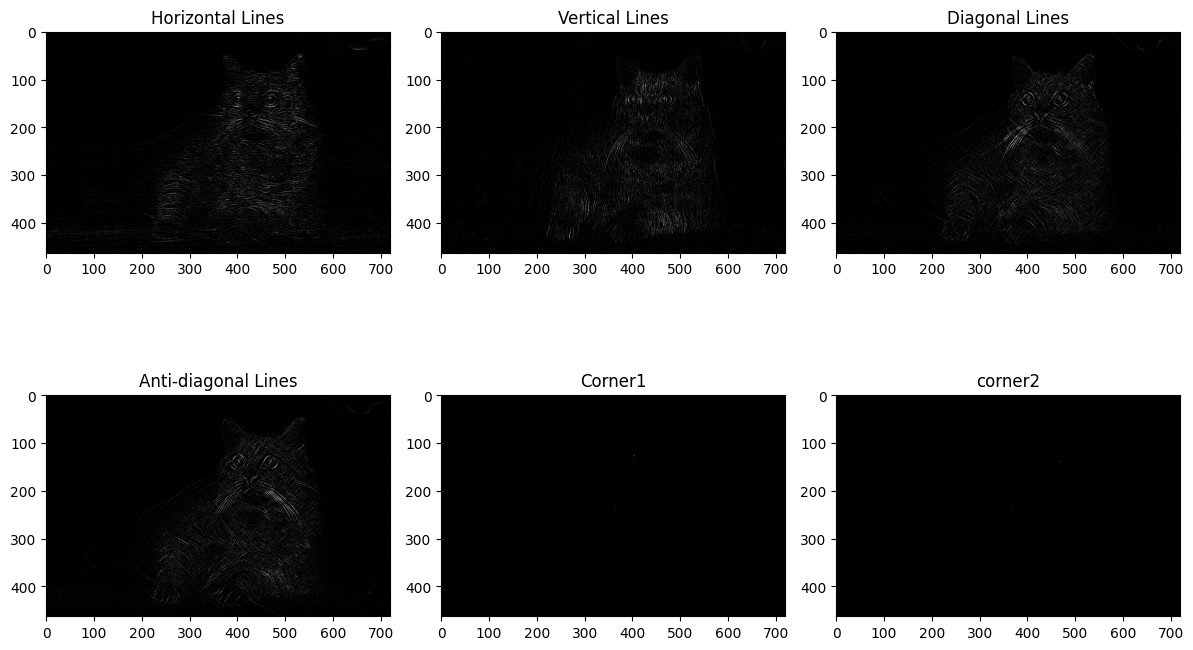

In [114]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(horizontal_lines, cmap='gray')
plt.title('Horizontal Lines')

plt.subplot(2, 3, 2)
plt.imshow(vertical_lines, cmap='gray')
plt.title('Vertical Lines')

plt.subplot(2, 3, 3)
plt.imshow(diagonal_lines, cmap='gray')
plt.title('Diagonal Lines')

plt.subplot(2, 3, 4)
plt.imshow(anti_diagonal_lines, cmap='gray')
plt.title('Anti-diagonal Lines')

plt.subplot(2, 3, 5)
plt.imshow(corner1, cmap='gray')
plt.title('Corner1')

plt.subplot(2, 3, 6)
plt.imshow(corner2, cmap='gray')
plt.title('corner2')

plt.tight_layout()
plt.show()